### Setup


In [1]:
# Googel Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zeyadusf","key":"613ca558509921f06751da24ad85b047"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download DataSet from kaggel
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

 18% 5.00M/28.0M [00:00<00:01, 22.3MB/s]
100% 28.0M/28.0M [00:00<00:00, 90.5MB/s]


In [5]:
import zipfile

with zipfile.ZipFile('/content/alzheimer-mri-dataset.zip', 'r') as zip_ref:
      zip_ref.extractall('/content/alzheimer-mri-dataset')

### import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,roc_curve, auc,confusion_matrix
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [7]:
DATA_SET_PATH = r'/content/alzheimer-mri-dataset/Dataset'
categories=os.listdir(DATA_SET_PATH)
categories



['Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented', 'Non_Demented']

In [8]:
# Encoding
def MyEncoder(Categories):
  classes_names={}
  for i in range(len(Categories)):
    classes_names[i]=Categories[i]
  return classes_names

In [9]:
classnames = MyEncoder(categories)
classnames

{0: 'Mild_Demented',
 1: 'Moderate_Demented',
 2: 'Very_Mild_Demented',
 3: 'Non_Demented'}

In [10]:
def CreateDataSet (PATH,dataList):

  for cat in categories :
    CAT_PATH = os.path.join(DATA_SET_PATH ,cat)

    for imgs in tqdm(os.listdir(CAT_PATH)):
      try:
            img=cv2.imread(os.path.join(CAT_PATH ,imgs))
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # conv channels from 3 to 1
            classNum=categories.index(cat)
            dataList.append([img,classNum])
      except Exception as e:
            print(e)



In [11]:
dataSet=[]
CreateDataSet(DATA_SET_PATH,dataSet)

100%|██████████| 3200/3200 [00:00<00:00, 4017.41it/s]


In [12]:
classnames[dataSet[9][1]]

'Mild_Demented'

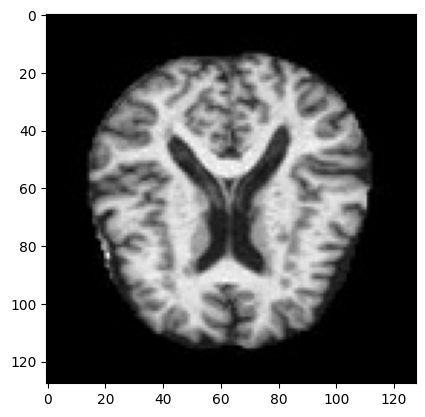

In [13]:
plt.imshow(dataSet[2][0], cmap='gray')
plt.show()

In [14]:
import random
random.shuffle(dataSet)


In [15]:
for trainSample in dataSet[:10]:
    print(classnames[trainSample[1]])

Non_Demented
Very_Mild_Demented
Non_Demented
Non_Demented
Non_Demented
Non_Demented
Non_Demented
Very_Mild_Demented
Non_Demented
Non_Demented


In [16]:
dataSet[0][0].shape

(128, 128)

#### Spilt Data


In [17]:
X=[]
Y=[]
for feature,label in dataSet:
    X.append(feature)
    Y.append(label)

In [18]:
x_train ,x_test ,y_train,y_test = train_test_split(X,Y,test_size=0.25,stratify=Y,random_state=42)
x_test,x_valid ,y_test,y_valid = train_test_split(x_test,y_test,test_size=0.60,stratify=y_test,random_state=42)

In [19]:
print(len(y_train))
for i in range(4) :
  print(i , " -- " , y_train.count(i))

4800
0  --  672
1  --  48
2  --  1680
3  --  2400


In [20]:
print(len(y_valid))
for i in range(4) :
  print(i , " -- " , y_valid.count(i))

960
0  --  134
1  --  10
2  --  336
3  --  480


In [21]:
print(len(y_test))
for i in range(4) :
  print(i , " -- " , y_test.count(i))

640
0  --  90
1  --  6
2  --  224
3  --  320


In [22]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_valid = np.array(x_valid)
y_valid = np.array(y_valid)
x_test = np.array(x_test)
y_test = np.array(y_test)


## Model

In [23]:
model= keras.Sequential([
    Conv2D(128,kernel_size=3,padding='same', activation='relu' ,input_shape=(128,128,1)),
    BatchNormalization(),
    MaxPool2D(2,padding='same'),

    Conv2D(64,kernel_size=3, activation='relu' ),
    BatchNormalization(),
    MaxPool2D(2),
    Dropout(0.3),

    Conv2D(32,kernel_size=3, activation='relu' ),
    BatchNormalization(),
    MaxPool2D(2,padding='same'),
    Dropout(0.3),

    Conv2D(16,kernel_size=3, activation='relu' ,padding='same'),
    BatchNormalization(),
    MaxPool2D(2),
    Dropout(0.3),

    Flatten(),
    Dropout(0.5),
    Dense(512),
    Dense(4, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        73792     
                                                                 
 batch_normalization_1 (Bat  (None, 62, 62, 64)        256       
 chNormalization)                                                
                                                        

In [25]:
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall()])

In [26]:
total_images = 4800
class_counts = [672, 48, 2400, 1680]

class_weights = {}
for i, count in enumerate(class_counts):
    class_weights[i] = total_images / (len(class_counts) * count)

print( class_weights)

{0: 1.7857142857142858, 1: 25.0, 2: 0.5, 3: 0.7142857142857143}


In [27]:
num_classes = 4  # Number of classes

y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_valid_encoded = to_categorical(y_valid, num_classes=num_classes)



In [ ]:
hist = model.fit(x=x_train, y=y_train_encoded, batch_size=32, epochs=60, validation_data=(x_valid, y_valid_encoded),
                 shuffle=True, class_weight=class_weights, validation_batch_size=64)

# 4 times with 15 epochs with class_weights
# 4 times with 30 epochs without class_weights
# 1 times with 60 epochs with class_weights
# total epochs = 240 epochs


In [ ]:
model.save('model.h5')


## Evaluation

In [28]:
model = load_model('/content/model.h5')

20/20 [==============================] - 8s 9ms/step


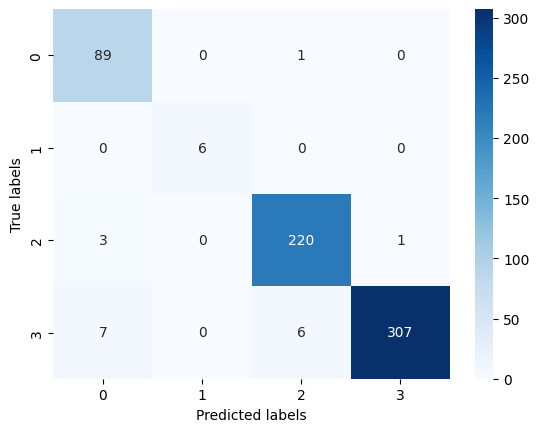

In [29]:
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
confusion_Matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(confusion_Matrix, annot=True, cmap='Blues',fmt='.3g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [30]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94        90
           1       1.00      1.00      1.00         6
           2       0.97      0.98      0.98       224
           3       1.00      0.96      0.98       320

    accuracy                           0.97       640
   macro avg       0.97      0.98      0.97       640
weighted avg       0.97      0.97      0.97       640



## test model

In [109]:
start = np.random.randint(25,60)
end =  start +21
x_evl = x_test[start:end]
y_evl = y_test[start:end]
pred_evl =y_pred[start:end]

# x_evl_processed = np.expand_dims(x_evl, axis=-1)  # Assuming grayscale images, add the channel dimension
# # Predict using the processed data
# pred_evl = model.predict(x_evl_processed)



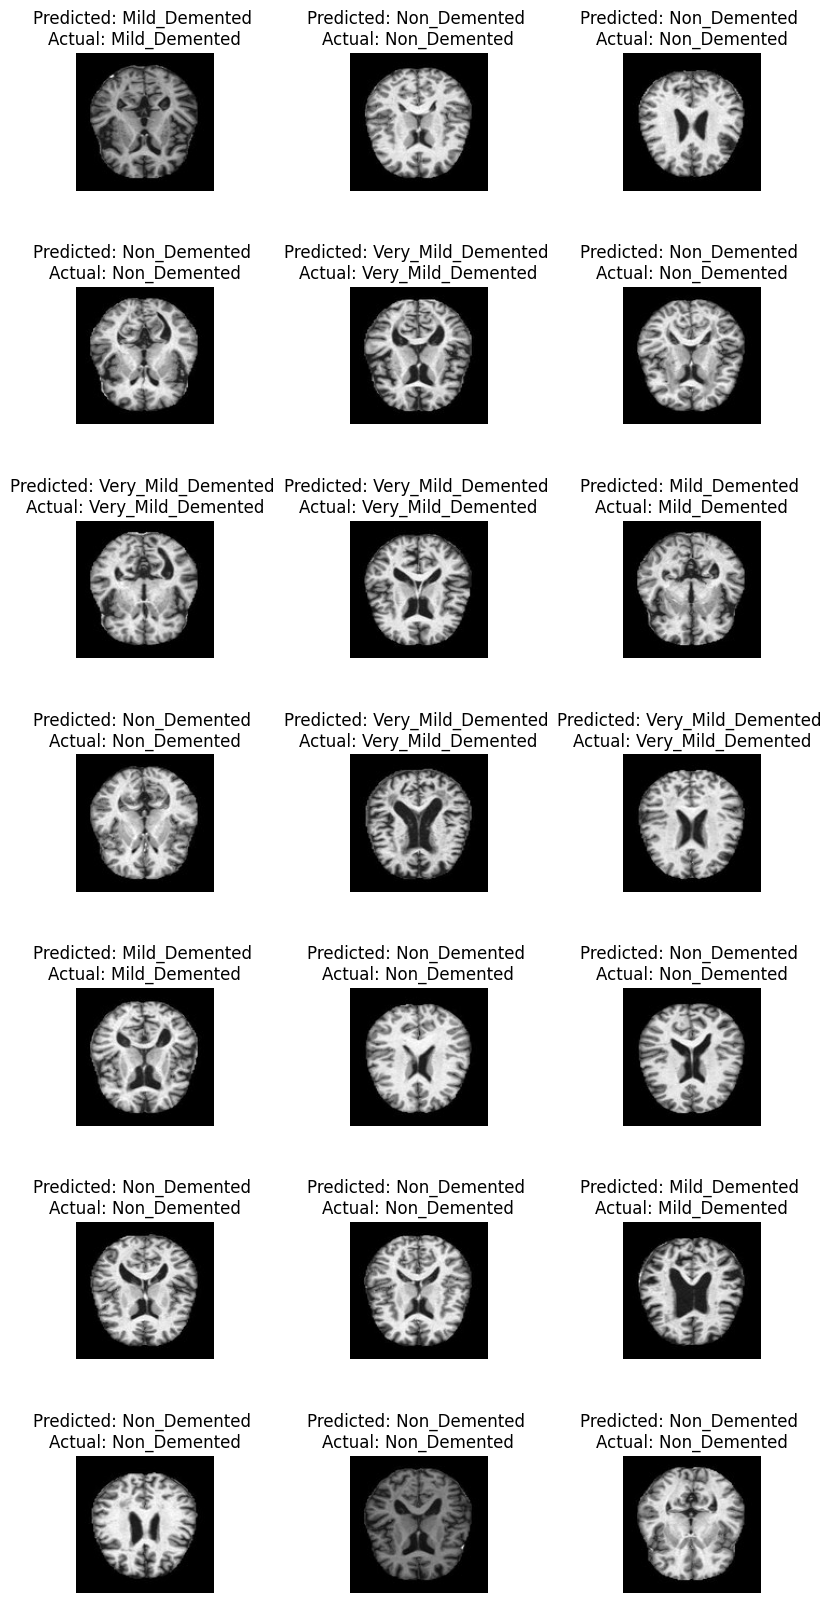

In [114]:
fig, axs = plt.subplots(7, 3, figsize=(10, 20))
axs = axs.flatten()

for i  in range(len(y_evl)):

  axs[i].imshow(x_evl[i], cmap='gray')
  predicted_class_index = np.argmax(pred_evl[i])  # Get the index of the highest probability class
  axs[i].set_title(f'Predicted: {classnames[predicted_class_index]} \nActual: {classnames[y_evl[i]]}')
  axs[i].axis('off')
  axs[i].axis('off')

plt.subplots_adjust(hspace=0.7)
plt.show()